In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.auto import tqdm, trange

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

In [2]:
pot = gp.CCompositePotential()
pot['disk'] = gp.MiyamotoNagaiPotential(
    m=6e10, a=3.5, b=0.28, units=galactic)
pot['halo'] = gp.NFWPotential.from_M200_c(
    M200=1e12*u.Msun, c=15, units=galactic)
pot['halo'] = gp.NFWPotential(
    m=pot['halo'].parameters['m'],
    r_s=pot['halo'].parameters['r_s'],
    b=0.95, c=0.9, units=galactic)

H = gp.Hamiltonian(pot)

### Compute a grid of orbits in x-z plane; vx=vz=0, set vy to keep E constant

In [43]:
from scipy.optimize import root

In [40]:
x0 = 15. * u.kpc
vy0 = 215 * u.km/u.s
fiducial_w0 = gd.PhaseSpacePosition(
    pos=[1., 0, 0] * x0,
    vel=[0, 1, 0] * vy0)
E0 = H.energy(fiducial_w0)[0].to( (u.km/u.s)**2 )

In [69]:
# _grid = np.arange(0, 30+1e-3, 0.2)
# xgrid, zgrid = map(np.ravel, np.meshgrid(_grid, _grid))

_xgrid = np.arange(5, 20+1e-3, 0.1)
_zgrid = np.arange(0, 7.5+1e-3, 0.1)
xgrid, zgrid = map(np.ravel, np.meshgrid(_xgrid, _zgrid)) 

def minfunc(vy, x, z):
    return 0.5*vy**2 + H.potential([x, 0, z]).to_value((u.km/u.s)**2) - E0.value

In [70]:
vygrid = np.full_like(xgrid, np.nan)
for n in trange(len(xgrid)):
    res = root(minfunc, 200., args=(xgrid[n], zgrid[n]))
    if res.success:
        vygrid[n] = res.x

(0.0, 30.0)

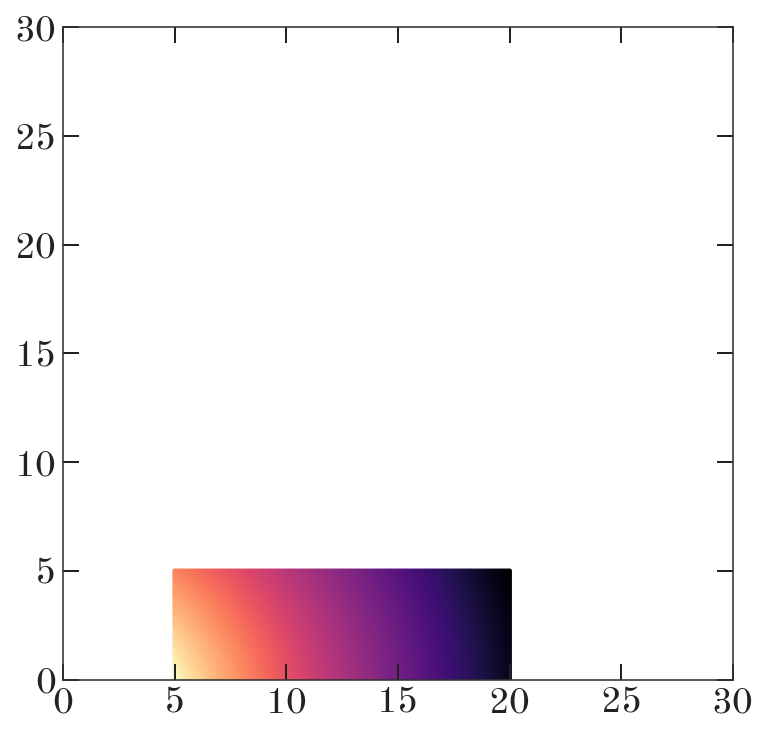

In [71]:
plt.figure(figsize=(6, 6))
plt.scatter(xgrid[np.isfinite(vygrid)], 
            zgrid[np.isfinite(vygrid)],
            c=vygrid[np.isfinite(vygrid)], s=2)
plt.xlim(0, 30)
plt.ylim(0, 30)

In [77]:
import superfreq as sf

In [85]:
def get_freqs(orbit):
    naff = sf.SuperFreq(orbit.t.value, keep_calm=True)
    
    if orbit.circulation().any():
        pp = gc.cartesian_to_poincare_polar(orbit.w().T)

        fs = [pp[:, 0] + 1j*pp[:, 3], 
              pp[:, 1] + 1j*pp[:, 4],
              pp[:, 2] + 1j*pp[:, 5]]
    else:
        fs = [orbit.x.value + 1j*orbit.v_x.value,
              orbit.y.value + 1j*orbit.v_y.value,
              orbit.vz.value + 1j*orbit.v_z.value]

    res = naff.find_fundamental_frequencies(fs)

    return res.fund_freqs

In [90]:
mask = np.isfinite(vygrid)
xs = xgrid[mask]
zs = zgrid[mask]
vys = vygrid[mask]

freqs = np.zeros((3, mask.sum(), 2))
for n in trange(mask.sum()):
    w0 = gd.PhaseSpacePosition(
        pos=[xs[n], 0, zs[n]] * u.kpc,
        vel=[0, vys[n], 0] * u.km/u.s)
    
    orbit = H.integrate_orbit(w0, dt=2., t1=0, t2=256 * 300.*u.Myr, 
                              Integrator=gi.DOPRI853Integrator)
    
    freqs[:, n, 0] = get_freqs(orbit[:orbit.ntimes // 2])
    freqs[:, n, 1] = get_freqs(orbit[orbit.ntimes // 2:])

In [98]:
freqdiff = freqs[..., 1] - freqs[..., 0]
absfreqdiff = np.linalg.norm(freqdiff, axis=0)

(-5.0, 5.0)

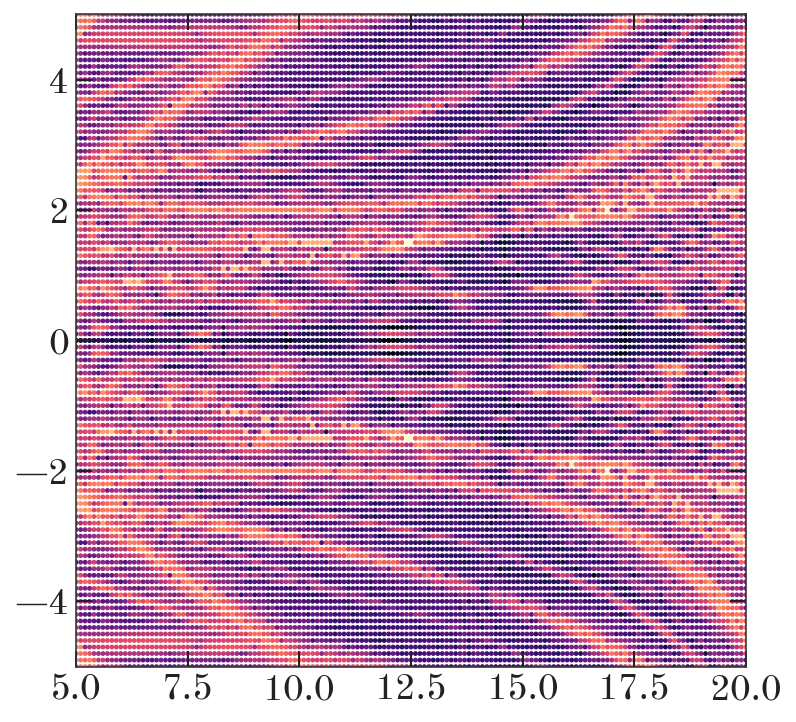

In [102]:
c = np.log10(absfreqdiff)

plt.figure(figsize=(6, 6))
plt.scatter(xgrid[np.isfinite(vygrid)], 
            zgrid[np.isfinite(vygrid)],
            c=c, s=2)
plt.scatter(xgrid[np.isfinite(vygrid)], 
            -zgrid[np.isfinite(vygrid)],
            c=c, s=2)
plt.xlim(5, 20)
plt.ylim(-5, 5)

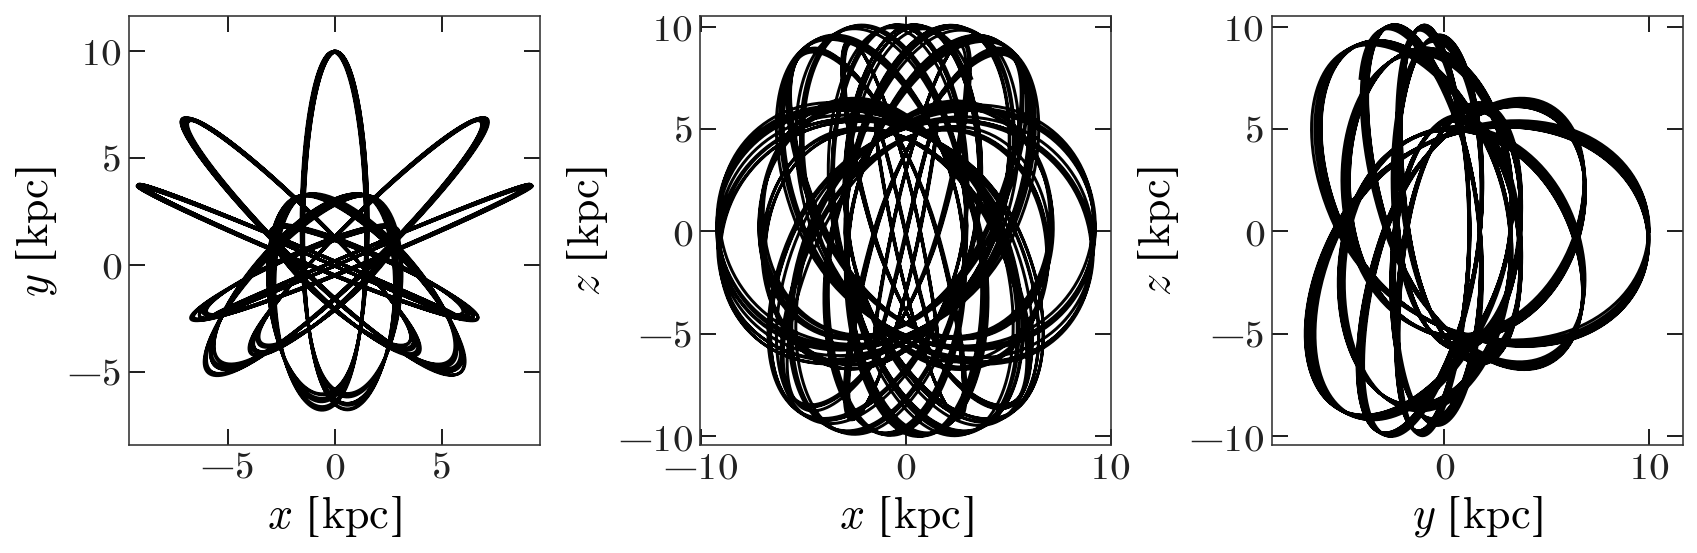

In [223]:
# for i in np.linspace(-0.01, 0.01, 20):
#     vx = 33.855789894736844 + i
#     fig.suptitle(vx)
#     print(vx)
    
w0 = gd.PhaseSpacePosition(pos=[0, 10., 0] * u.kpc,
                           vel=[33.855789894736844, 0, 150.] * u.km/u.s)
#                            vel=[10, 0, 150.] * u.km/u.s)
#                            vel=[0, 25, 150.] * u.km/u.s)

tmp = pot.integrate_orbit(w0, dt=2., n_steps=10000, 
                          Integrator=gi.DOPRI853Integrator)
fig = tmp.plot()

In [224]:
# dt, nsteps = gd.estimate_dt_n_steps(
#     w0, H, n_periods=256, n_steps_per_period=1024)

dt = 0.1
nsteps = 10_000_000

In [226]:
orbit = pot.integrate_orbit(w0, dt=dt, n_steps=nsteps, 
                            Integrator=gi.DOPRI853Integrator)

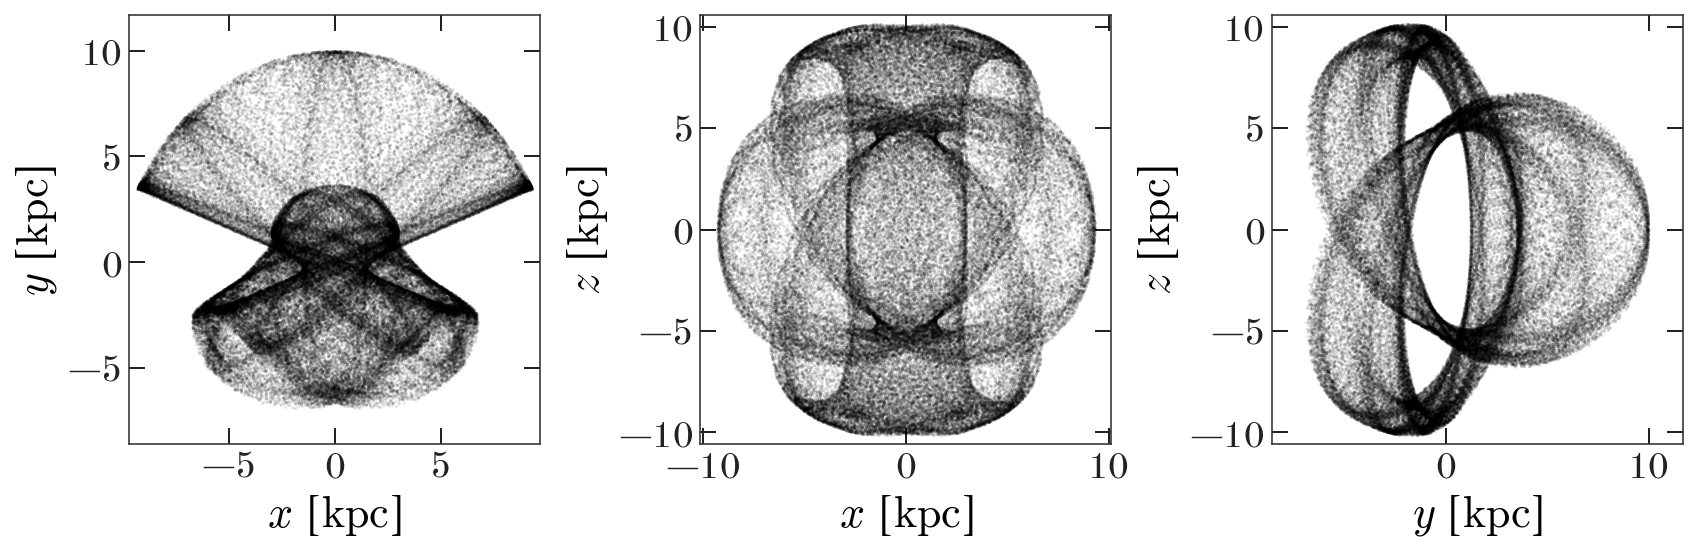

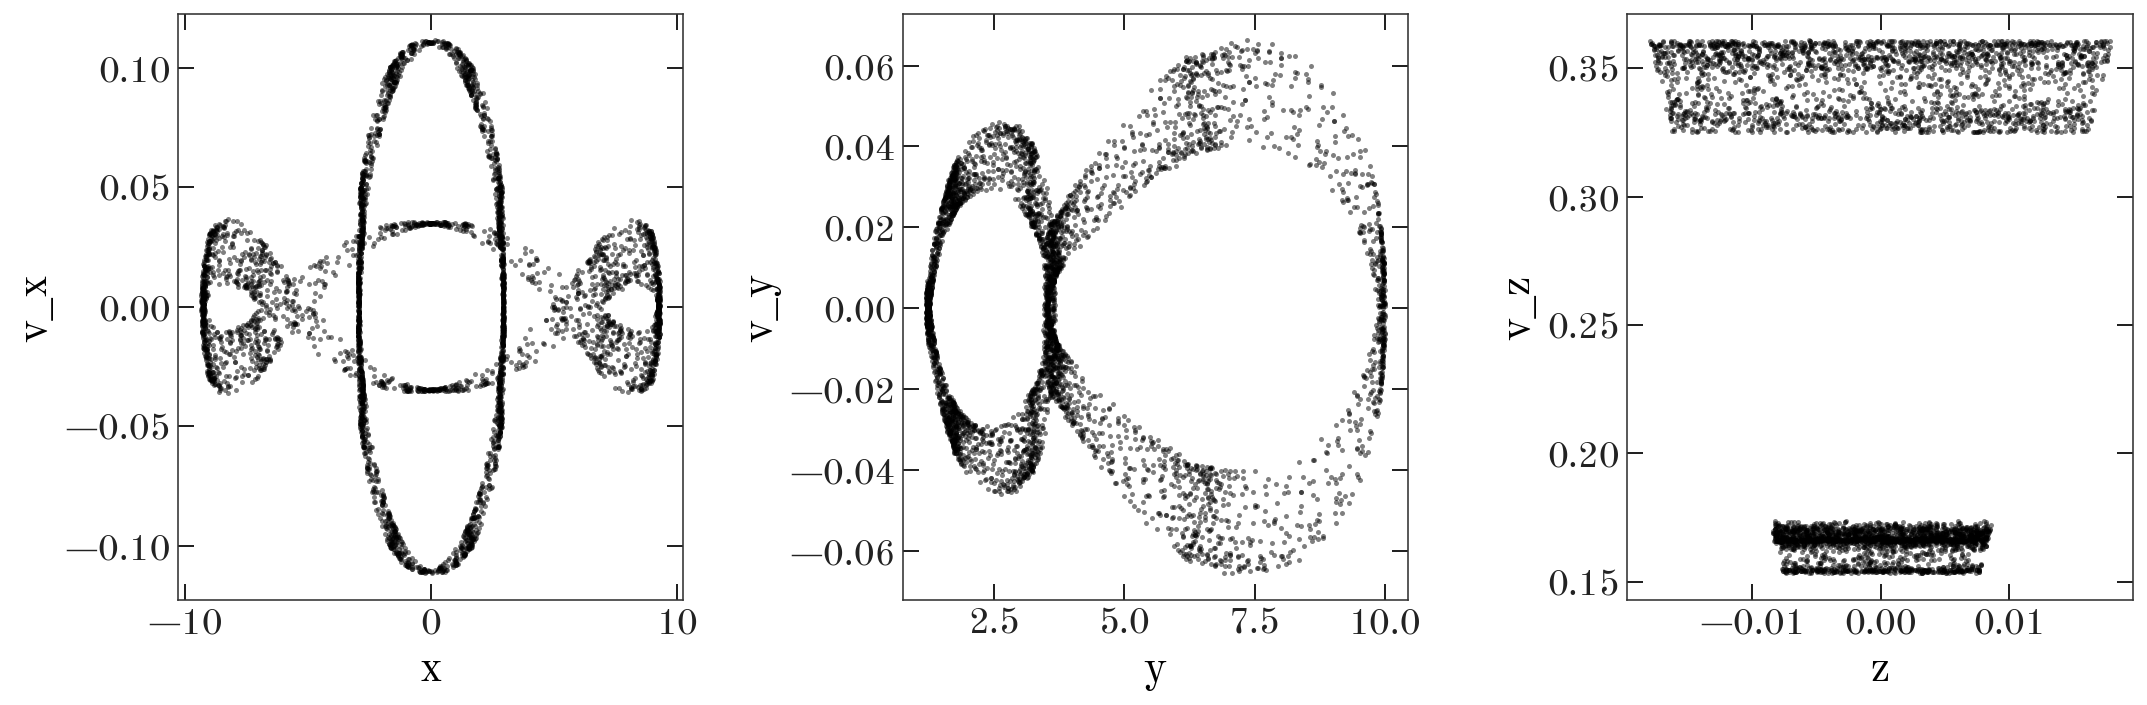

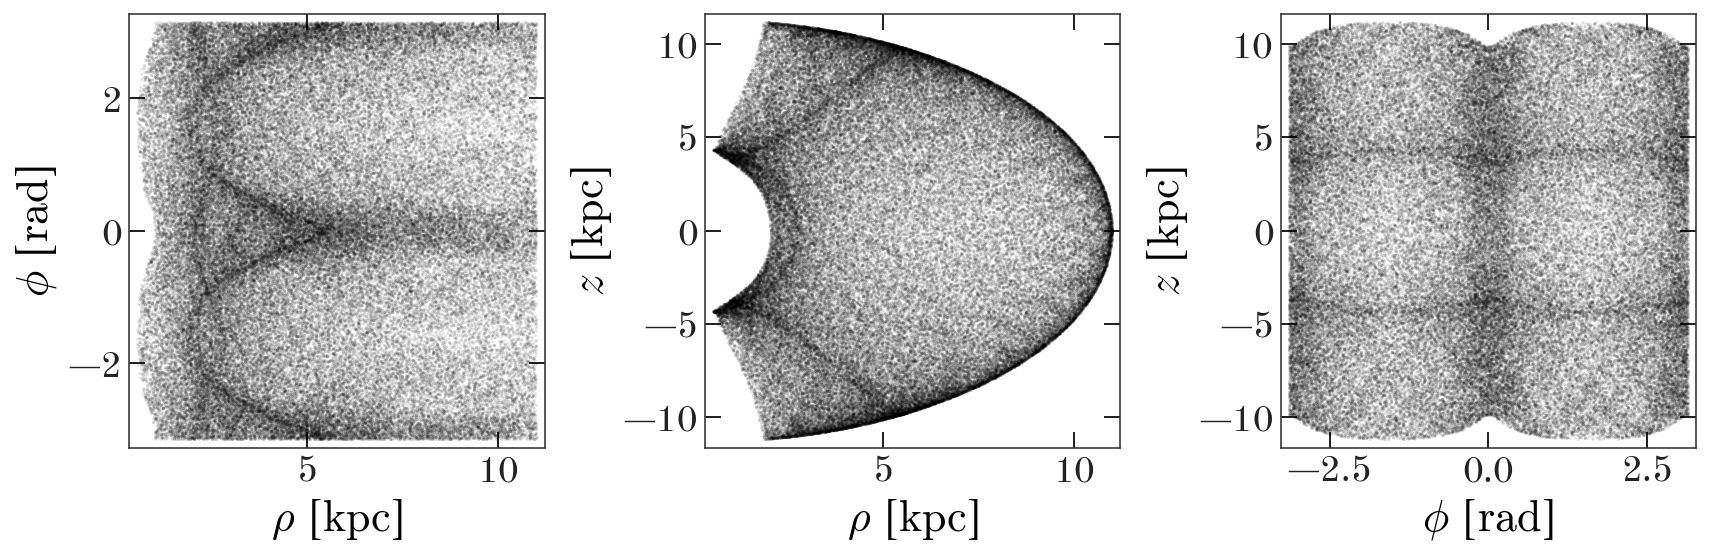

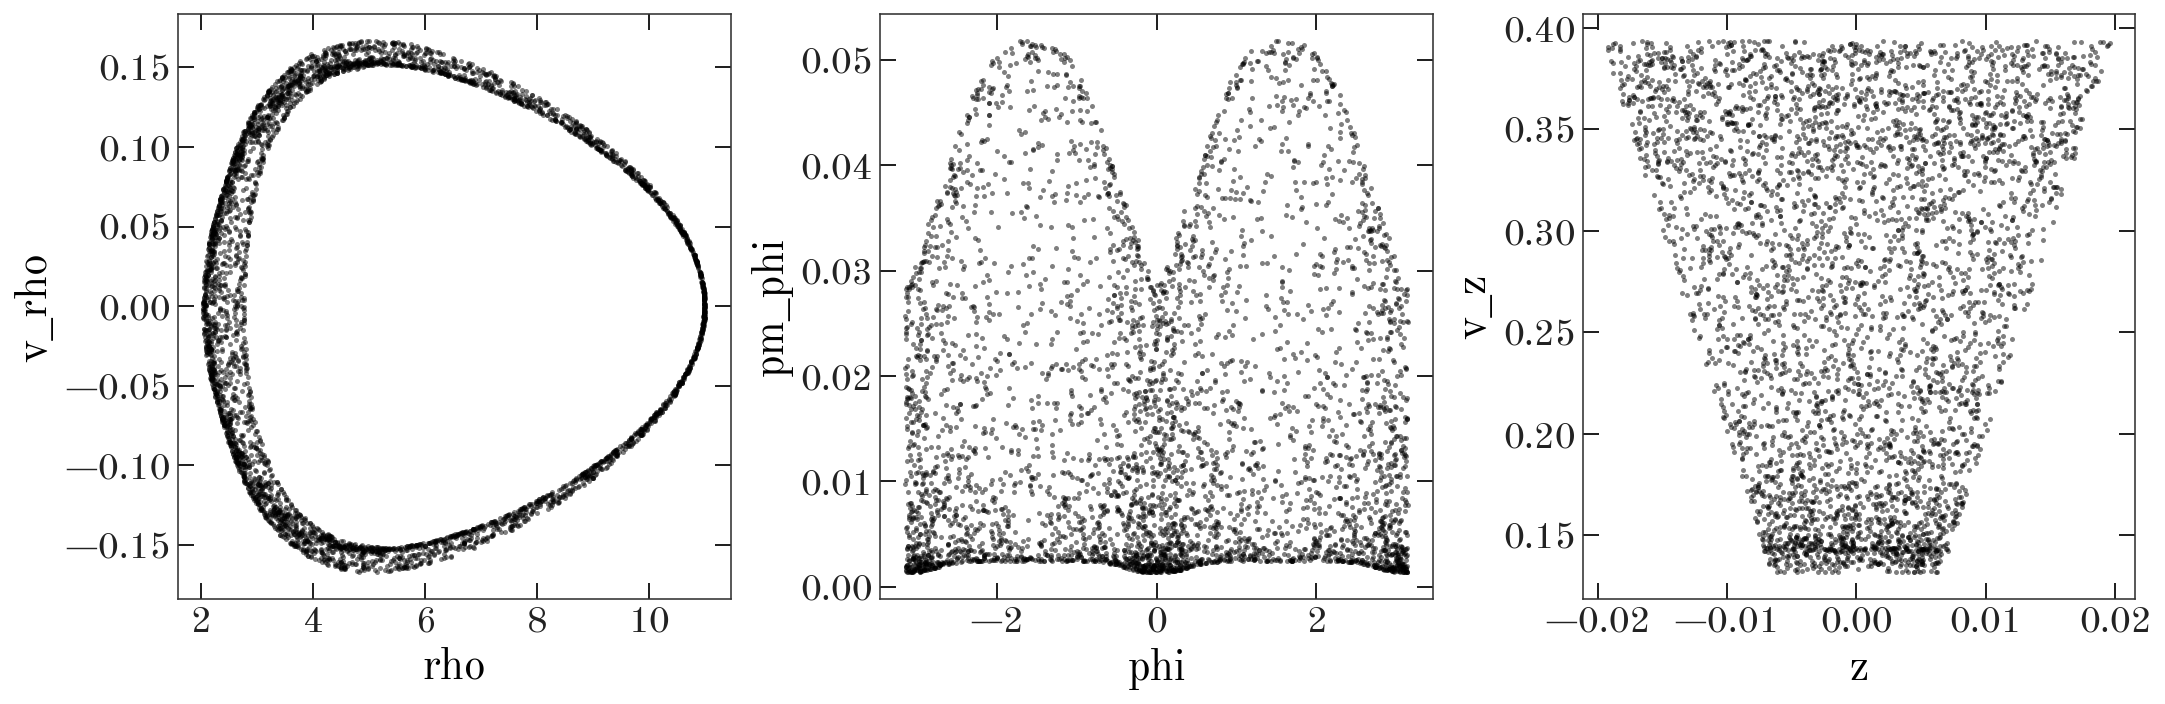

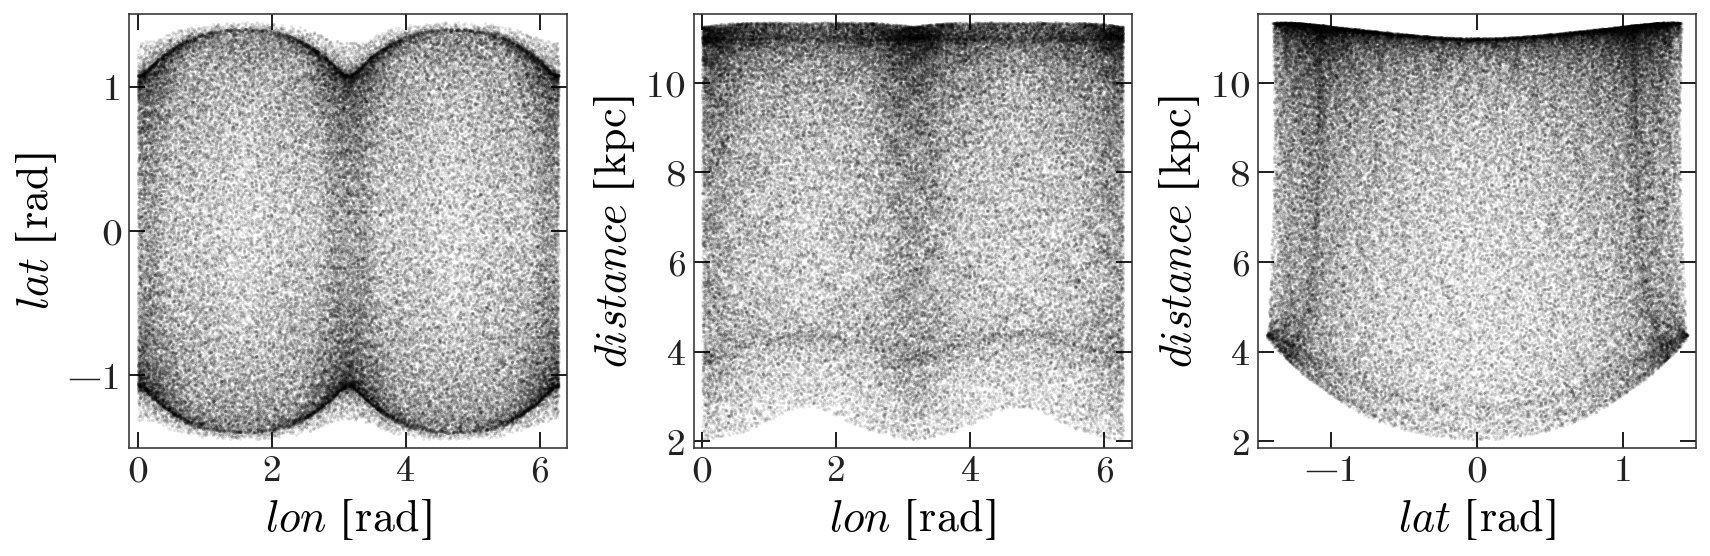

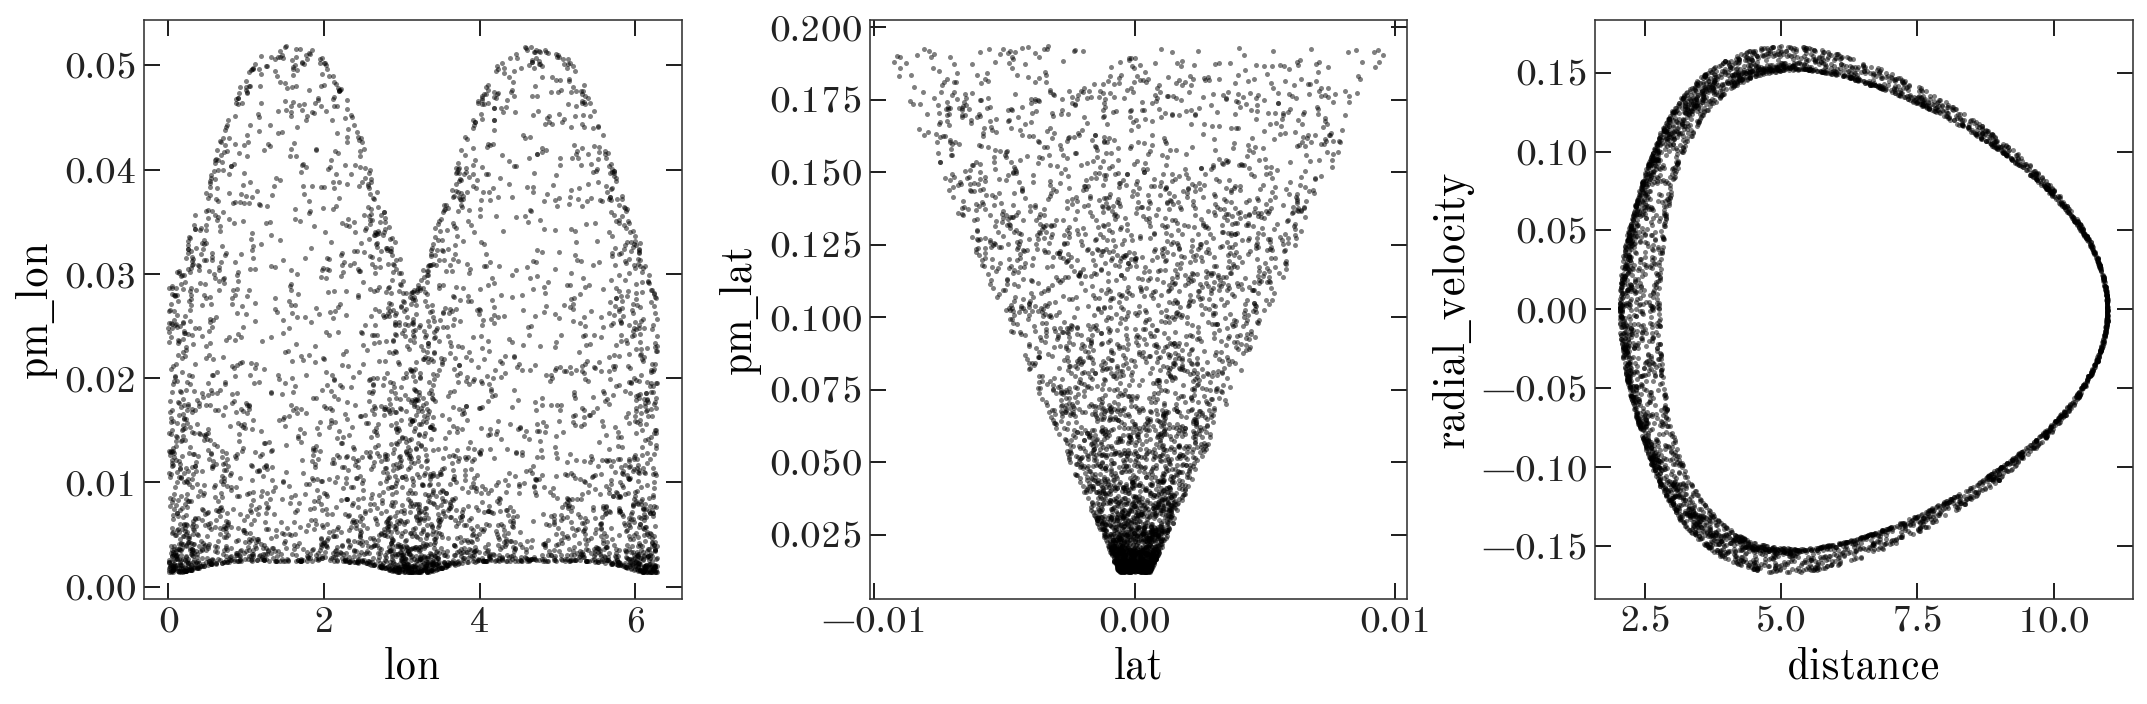

In [229]:
for o, idx in zip([orbit, o.cylindrical, o.spherical],
                  [2, 2, 1]):
    sos = surface_of_section(o, constant_idx=idx)
    
    fig = o[::100].plot(marker='o', ms=1.5, alpha=0.1, mew=0, linestyle='none')
    fig.set_facecolor('w')
    
    # SoS:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5.))
    for i in range(3):
        ax = axes[i]
        
        x1 = list(o.pos_components)[i]
        x2 = list(o.vel_components)[i]
        
        ax.plot(getattr(sos, x1), 
                getattr(sos, x2), 
                ls='none', marker='o', mew=0, alpha=0.5, ms=2.5)

        ax.set_xlabel(f'{x1}')
        ax.set_ylabel(f'{x2}')

    fig.tight_layout()
    fig.set_facecolor('w')

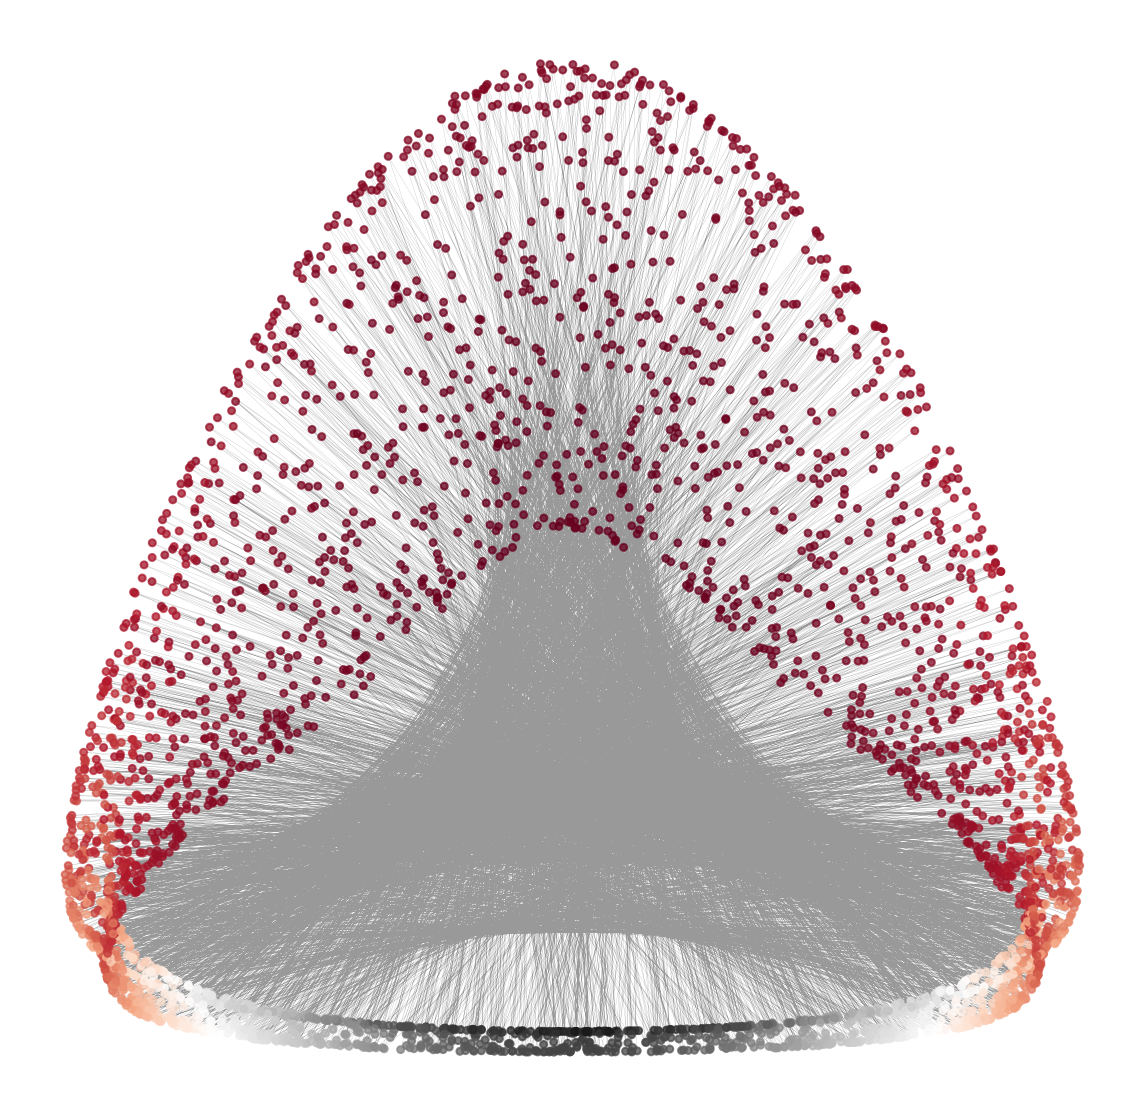

In [275]:
s = sos[:3500]

fig = plt.figure(figsize=(10, 10))
plt.plot(s.radial_velocity.value,
         s.pm_lon.value,
         marker='', linestyle='-', 
         mew=0, alpha=0.4, lw=0.1, color='k')

plt.scatter(s.radial_velocity.value,
            s.pm_lon.value,
            c=1 / s.pm_lat.value,
            marker='o', s=12, alpha=0.75, 
            cmap='RdGy', zorder=10)
ax = plt.gca()

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for k, s in ax.spines.items():
    s.set_visible(False)